In [17]:
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
import pandas as pd
from glob import glob
import scipy.signal as signal
import cartopy.crs as ccrs

In [2]:

def filter_timeseries(ts, order, cutoff, btype='lowpass', fs=1, **kwargs):
    """Given an array, this function apply a butterworth (high/low pass) 
    filter of the given order and cutoff frequency.
    For example:
    If 'ts' is a timeseries of daily samples, filter_timeseries(ts,3,1/20)
    will return the series without the 20 days or less variability using an
    order 3 butterworth filter. 
    In the same way, filter_timeseries(ts,3,1/20, btype='highpass') will
    return the series with only the 20 days or less variability.

    Args:
        ts (array_like): timeseries or 1D array to filter
        order (int): _description_
        cutoff (array_like): Single float for lowpass or highpass filters, 
        arraylike for bandpass filters.
        btype (str, optional): The type of filter. Defaults to 'lowpass'.
        fs (int): Sampling frequency. Defaults to 1
        **kwargs are passed to scipy.signal.filtfilt

    Returns:
        output (array): Filtered array
    """
    mask = np.isnan(ts)
    nans = np.ones(len(ts))*np.nan
    if mask.sum()==len(ts):
        return nans
    else:
        b, a = signal.butter(order, cutoff, btype=btype, fs=fs)
        filt=signal.filtfilt(b, a, ts[~mask], **kwargs)
        output=np.ones(len(ts))*np.nan
        output[np.where(~mask)] = filt
        return output
    
def filter_xarray(data, dim, order, cutoff, btype='lowpass', parallel=False, fs=1):
    """Given a 3d DataArray, with time and spatial coordinates, this function apply
    the 1D function filter_timeseries along the time dimension, filter the complete
    xarray data.

    Args:
        data (XDataArray): data
        dim (str): name of the time dimension
        order (int): butterworth filter order
        cutoff (array_like): if float, the cutoff frequency, if array must be the
                            [min,max] frequencys for the bandpass filter.
        btype (str, optional): {lowpass,highpass,bandpass}. Defaults to 'lowpass'.
        parallel (bool, optional): If parallelize with dask. Defaults to False.
        fs (int, optional): Sampling frequency. Defaults to 1.

    Returns:
        XDataArray: filtered data
    """
    if parallel:
        dask='parallelized'
    else:
        dask='forbidden'
    filt = xr.apply_ufunc(filter_timeseries, data, order, cutoff, btype, fs,
                          input_core_dims=[[dim],[],[],[],[]],
                          output_core_dims=[[dim]],
                          exclude_dims=set((dim,)),
                          keep_attrs=True,
                          vectorize=True, dask=dask)
    filt[dim] = data[dim]
    return filt



In [45]:
masks_reforecast = xr.open_dataset('data/REFORECASTS_MASKS.nc')
masks_glorys     = xr.open_dataset('data/GLORYS_MASKS.nc')

In [3]:
#LOAD DATA

tropical_glorys_clim       = xr.open_dataset('data/GLORYS12V1/HOVMOLLERS/CLIMATOLOGY/glorys_tropical.nc')
coastnorth_glorys_clim     = xr.open_dataset('data/GLORYS12V1/HOVMOLLERS/CLIMATOLOGY/glorys_coastnorth.nc')
coastsouth_glorys_clim     = xr.open_dataset('data/GLORYS12V1/HOVMOLLERS/CLIMATOLOGY/glorys_coastsouth.nc')

tropical_reforecast_clim   = xr.open_dataset('data/S2S/CLIMATOLOGY/reforecasts_tropical_clim.nc')
coastnorth_reforecast_clim = xr.open_dataset('data/S2S/CLIMATOLOGY/reforecasts_coastnorth_clim.nc')
coastsouth_reforecast_clim = xr.open_dataset('data/S2S/CLIMATOLOGY/reforecasts_coastsouth_clim.nc')

tropical_glorys       = xr.open_dataset('data/GLORYS12V1/HOVMOLLERS/glorys_tropical.nc').convert_calendar('noleap', dim='time')
tropical_reforecast   = xr.open_dataset('data/S2S/HOVMOLLERS/reforecasts_tropical.nc').convert_calendar('noleap', dim='inittime')

coastnorth_glorys     = xr.open_dataset('data/GLORYS12V1/HOVMOLLERS/glorys_coastnorth.nc').convert_calendar('noleap', dim='time')
coastnorth_reforecast = xr.open_dataset('data/S2S/HOVMOLLERS/reforecasts_coastnorth.nc').convert_calendar('noleap', dim='inittime')

coastsouth_glorys     = xr.open_dataset('data/GLORYS12V1/HOVMOLLERS/glorys_coastsouth.nc').convert_calendar('noleap', dim='time')
coastsouth_reforecast = xr.open_dataset('data/S2S/HOVMOLLERS/reforecasts_coastsouth.nc').convert_calendar('noleap', dim='inittime')

In [4]:
# COMPUTE REANALYSIS ANOMALIES
north_glorys = xr.concat([tropical_glorys.groupby('time.dayofyear')-tropical_glorys_clim,
                          coastnorth_glorys.groupby('time.dayofyear')-coastnorth_glorys_clim
                         ],'index').convert_calendar('gregorian').drop('dayofyear')

south_glorys = xr.concat([tropical_glorys.groupby('time.dayofyear')-tropical_glorys_clim,
                          coastsouth_glorys.groupby('time.dayofyear')-coastsouth_glorys_clim
                         ],'index').convert_calendar('gregorian').drop('dayofyear')


In [5]:
# COMPUTE ANOMALY FORECAST
north_reforecast = xr.concat([tropical_reforecast.groupby('inittime.dayofyear')-tropical_reforecast_clim,
                          coastnorth_reforecast.groupby('inittime.dayofyear')-coastnorth_reforecast_clim
                         ],'index').convert_calendar('gregorian', dim='inittime').drop('dayofyear')

south_reforecast = xr.concat([tropical_reforecast.groupby('inittime.dayofyear')-tropical_reforecast_clim,
                          coastsouth_reforecast.groupby('inittime.dayofyear')-coastsouth_reforecast_clim
                         ],'index').convert_calendar('gregorian', dim='inittime').drop('dayofyear')

In [42]:
zones_south = {'NorthPeru':slice(-3,-12),
               'SouthPeru':slice(-13,-17),
               'Atacama':slice(-18,-27),
               'CentralChile':slice(-28,-33)}

zones_north = {'SouthCCS':slice(30,34)}

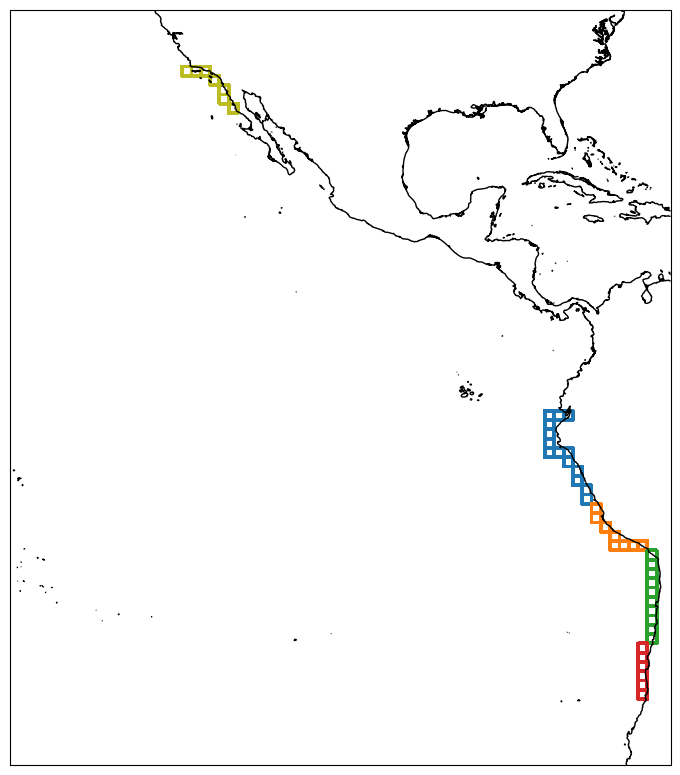

In [75]:
fig, ax = plt.subplots(1,1, figsize=(10,10), dpi=100, facecolor='w', subplot_kw={'projection':ccrs.PlateCarree()})
ax.coastlines('10m')
ax.set_extent([-140,-69,-35,35])



colors=plt.cm.tab10(np.linspace(0,1,10))
for i,z in enumerate(zones_south.keys()):    
    x = masks_reforecast.coastmask_south.sortby('lat',ascending=False).sel(lat=zones_south[z])
    x = x.where(x==1)
    ax.pcolor(x.lon,x.lat,x, color=colors[i], facecolor='none', linewidth=2)

colors=plt.cm.tab10(np.linspace(0.8,1,10))
for i,z in enumerate(zones_north.keys()):    
    x = masks_reforecast.coastmask_north.sortby('lat',ascending=True).sel(lat=zones_north[z])
    x = x.where(x==1)
    ax.pcolor(x.lon,x.lat,x, color=colors[i], facecolor='none', linewidth=2)



In [82]:
zsouth_reforecast = {keys:south_reforecast.swap_dims({'index':'lat'}).sel(lat=zones_south[keys]).mean('lat') for keys in zones_south.keys()}
zsouth_glorys     = {keys:south_glorys.swap_dims({'index':'lat'}).sel(lat=zones_south[keys]).mean('lat') for keys in zones_south.keys()}

znorth_reforecast = {keys:north_reforecast.swap_dims({'index':'lat'}).sel(lat=zones_north[keys]).mean('lat') for keys in zones_north.keys()}
znorth_glorys     = {keys:north_glorys.swap_dims({'index':'lat'}).sel(lat=zones_north[keys]).mean('lat') for keys in zones_north.keys()}


In [236]:
znorth_skill = {keys:None for keys in zones_north.keys()}
for z in zones_north.keys():
    print(z,'\n')
    reforecast = znorth_reforecast[z]
    glorys     = znorth_glorys[z].drop('sst')
    glorys.coords['time'] = glorys.time-pd.Timedelta(hours=12)
    glorys = glorys.convert_calendar('noleap')
    skill = []
    for lead in reforecast.leadtime.values:
        if lead%6==1:
            print('lead',lead)
        x = reforecast.sel(leadtime=lead).drop_duplicates('inittime').convert_calendar('noleap','inittime')
        x.coords['time'] = x.inittime+pd.Timedelta(days=lead)
        x = x.swap_dims({'inittime':'time'})
        x = x.interp(time=glorys.time.values)
        x.coords['inittime'] = x.time-pd.Timedelta(days=lead)
        x = x.groupby('inittime.dayofyear')
        y = glorys.groupby('time.dayofyear')
        skilldayofyear = []
        for i in range(1,365+1):
            xx = x[i].drop('time').rename({'inittime':'time'}).dropna('time')
            yy = y[i].reindex({'time':xx.time.values})
            c = []
            for v in xx.keys():
                c.append(xr.corr(xx[v],yy[v],'time'))
            skilldayofyear.append(xr.merge(c))
        skill.append(xr.concat(skilldayofyear, 'dayofyear'))
    skill = xr.concat(skill,'leadtime')
    znorth_skill[z] = skill.copy()

SouthCCS 

lead 1
lead 7
lead 13
lead 19
lead 25
lead 31
lead 37
lead 43


In [270]:
zsouth_skill = {keys:None for keys in zones_south.keys()}
for z in list(zones_south.keys()):
    print(z,'\n')
    reforecast = zsouth_reforecast[z]
    glorys     = zsouth_glorys[z].drop('sst')
    glorys.coords['time'] = glorys.time-pd.Timedelta(hours=12)
    glorys = glorys.convert_calendar('noleap')
    skill = []
    for lead in reforecast.leadtime.values:
        if lead%6==1:
            print('lead',lead)
        x = reforecast.sel(leadtime=lead).drop_duplicates('inittime').convert_calendar('noleap','inittime')
        x.coords['time'] = x.inittime+pd.Timedelta(days=lead)
        x = x.swap_dims({'inittime':'time'})
        x = x.interp(time=glorys.time.values)
        x.coords['inittime'] = x.time-pd.Timedelta(days=lead)
        x = x.groupby('inittime.month')
        y = glorys.groupby('time.month')
        skilldayofyear = []
        for i in range(1,12+1):
            xx = x[i].drop('time').rename({'inittime':'time'}).dropna('time')
            yy = y[i].reindex({'time':xx.time.values})
            c = []
            for v in xx.keys():
                c.append(xr.corr(xx[v],yy[v],'time'))
            skilldayofyear.append(xr.merge(c))
        skill.append(xr.concat(skilldayofyear, 'month'))
    skill = xr.concat(skill,'leadtime')
    zsouth_skill[z] = skill.copy()

NorthPeru 

lead 1
lead 7
lead 13
lead 19
lead 25
lead 31
lead 37
lead 43
SouthPeru 

lead 1
lead 7
lead 13
lead 19
lead 25
lead 31
lead 37
lead 43
Atacama 

lead 1
lead 7
lead 13
lead 19
lead 25
lead 31
lead 37
lead 43
CentralChile 

lead 1
lead 7
lead 13
lead 19
lead 25
lead 31
lead 37
lead 43


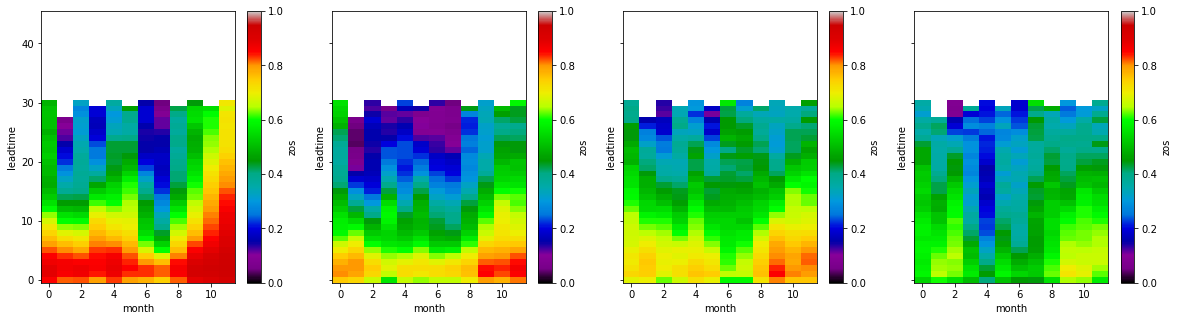

In [271]:
fig, ax = plt.subplots(1,4, sharex=True, sharey=True, figsize=(20,5))
for i,k in enumerate(zones_south.keys()):
    (zsouth_skill[k].zos**2).plot(ax=ax[i], vmin=0, vmax=1, cmap='nipy_spectral')

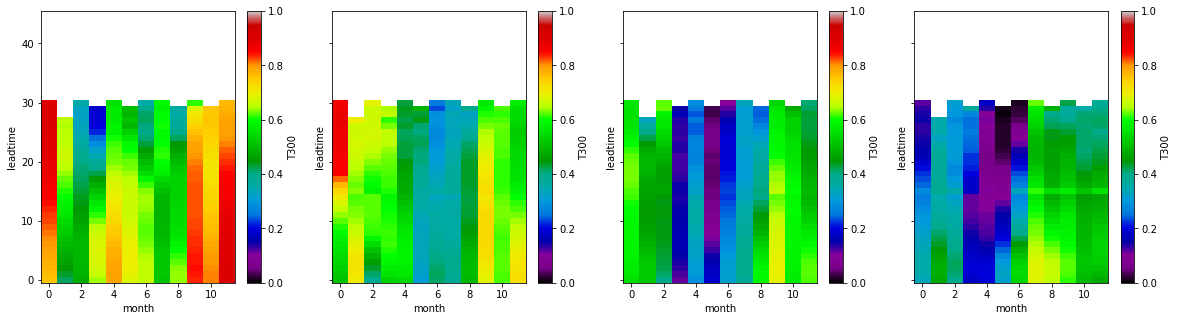

In [272]:
fig, ax = plt.subplots(1,4, sharex=True, sharey=True, figsize=(20,5))
for i,k in enumerate(zones_south.keys()):
    (zsouth_skill[k].T300**2).plot(ax=ax[i], vmin=0, vmax=1, cmap='nipy_spectral')